# Regression - Executive Summary

## Project Overview
The goal of this project is to determine cancer mortality rates by US county using data aggregated from a number of sources including the American Community Survey (census.gov), clinicaltrials.gov, and cancer.gov. The dataset for this project can be found at [data.world](https://data.world/nrippner/ols-regression-challenge)

#### The following types of data are being provided to predict death rate. 
- Incidence and Death Rates (aggregate and per capita)
- Economic Data (income, poverty, etc.)
- Age and Household Data
- Education Data
- Employment Data
- Health Coverage Data
- Race and other Demographic Data


*Note: There is a full Data Dictionary in the Appendix at the end of this notebook.*

## Import Data Exploration Tools

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import scipy.stats as stats
import pickle

## Data Exploration
After we cleaned our data by correcting for missing data and eliminating erroneous data we were left with 2,865 records. Our targe variable (Death Rates per 100,00) is generally normally distributed with a mean of 178.64 deaths per 100,000.  Death rates per 100,000 of less than 50 or greater than 260 deaths would be considered unusually low or high, respectively.

In [2]:
df = pd.read_csv('cancer_reg_cleaned.csv', index_col=[0])
len(df)

2865

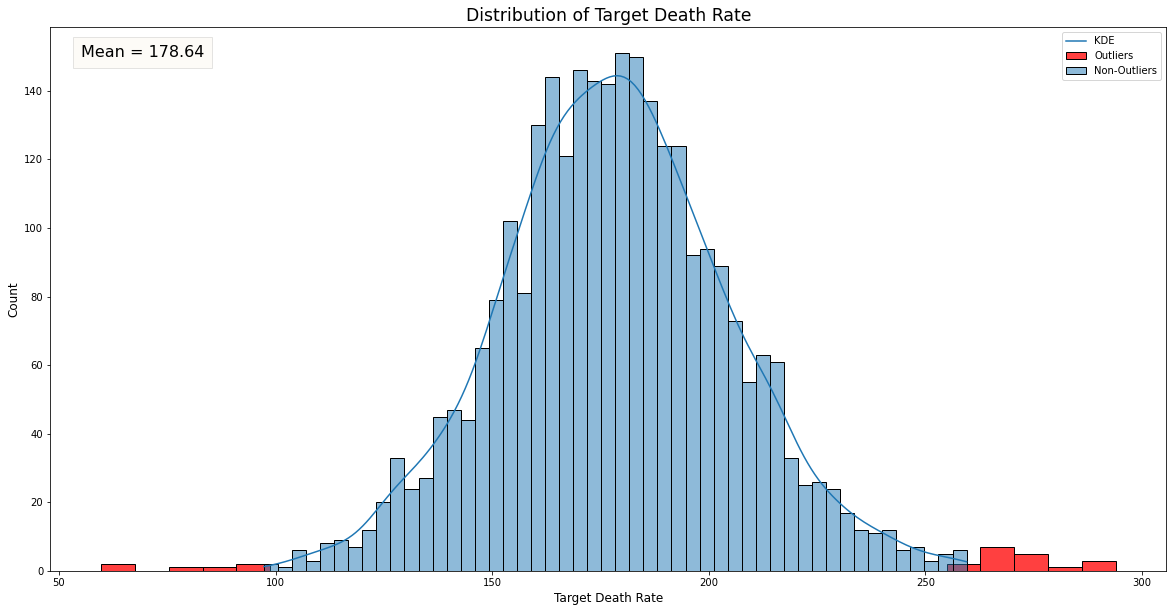

In [3]:
#look for values more than 3 standard deviations away from the mean.
mean = df['TARGET_deathRate'].mean()
std = np.std(df['TARGET_deathRate'])
upper_thresh = mean + (3 * std)
lower_thresh = mean - (3 * std)

outliers = df[(df['TARGET_deathRate'] < lower_thresh) | (df['TARGET_deathRate'] > upper_thresh)]
non_outliers = df[(df['TARGET_deathRate'] >= lower_thresh) & (df['TARGET_deathRate'] <= upper_thresh)]

plt.figure(figsize=(20,10))
sns.histplot(x='TARGET_deathRate', data=outliers, bins=30, color='r')
sns.histplot(x='TARGET_deathRate', data=non_outliers, bins=50, alpha=0.5, kde=True)
plt.title('Distribution of Target Death Rate', fontdict={'fontsize': 'xx-large'})
plt.xlabel('Target Death Rate',fontdict={'fontsize': 'large'})
plt.ylabel('Count',fontdict={'fontsize': 'large'})
plt.legend(['KDE', 'Outliers', 'Non-Outliers'])
plt.text(55, 150, "Mean = {:.2f}".format(mean), fontsize=16, bbox=dict(boxstyle='square', facecolor='wheat', 
                                                                       pad=0.5, alpha=0.1))
plt.show()

### Correlation with Dependent Variable
Several of our variables have correlations with our target variable. The highest absolute correlations (positive or negative) are related to Insurance Coverage and Education.  In looking at the data below there are 2 key takeaways.  
 1. The higher the incidence rate of cancer, the higher the expected death rate (this seems quite logical).
 2. Class status (as defined by eduction, income, health coverage) impacts expected death rate.

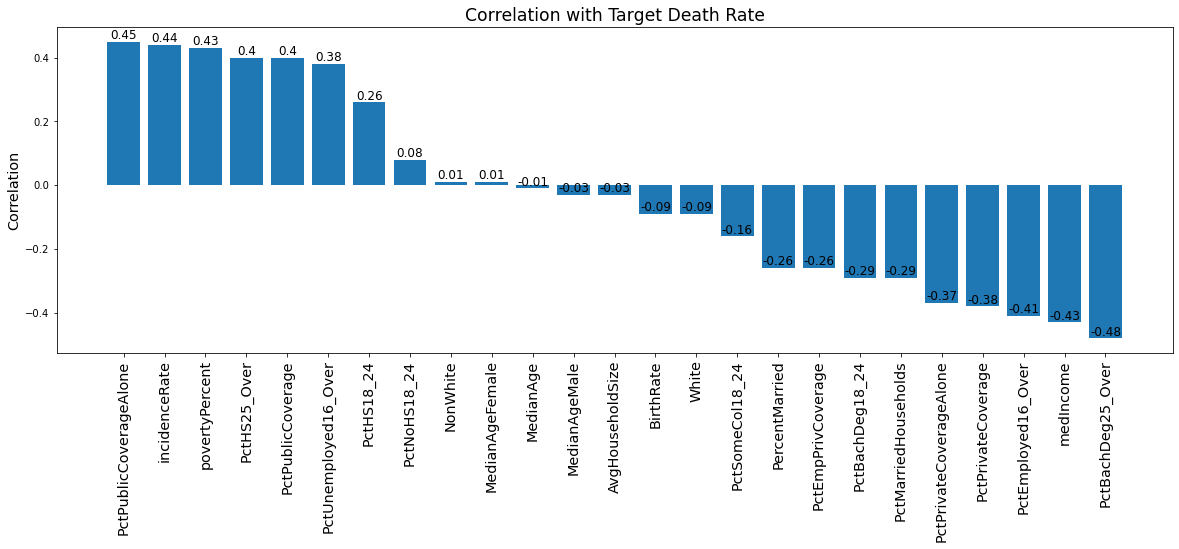

In [4]:
corr = round(df.corr()['TARGET_deathRate'].sort_values(ascending=False),2)
corr = corr.drop('TARGET_deathRate')
x = range(len(corr))
y = corr.values

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha='center', va = 'bottom', fontsize='large')

plt.figure(figsize=(20,6))
plt.bar(x, y, align='center')
addlabels(x, y)
plt.xticks(range(len(corr)), corr.index, rotation = 90, fontsize='x-large')
plt.title('Correlation with Target Death Rate', size='xx-large')
plt.ylabel('Correlation', size='x-large')

plt.show()

## Regression Analysis
I applied several linear and non-linear models to the dataset.  Below is a summary of the regression metrics for each of the models I applied.

In [5]:
linear_models = pd.read_csv('linear_metrics.csv')
alternative_models = pd.read_csv('alternative_metrics.csv')
all_models = pd.concat([linear_models, alternative_models])
all_models = all_models.drop('Unnamed: 0', axis=1)

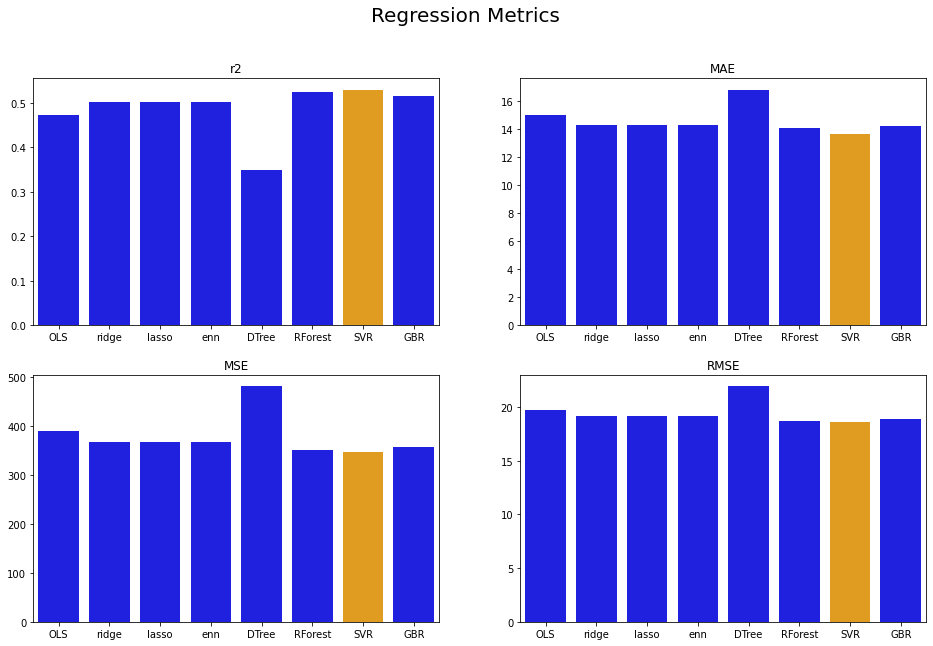

In [6]:
i, j = 0, 0
plots_per_row = 2
fig, axs = plt.subplots(math.ceil(len(all_models.drop('metric', axis=1).columns)/plots_per_row), plots_per_row, 
                        figsize=(16, 10))

for col in all_models.drop('metric', axis=1).columns:
    values = np.array(all_models[col])
    if col == 'r2':
        clrs = ['blue' if (x < max(values)) else 'orange' for x in values]
    else:
        clrs = ['blue' if (x > min(values)) else 'orange' for x in values] 
    sns.barplot(x='metric', y=col, data=all_models, palette=clrs, ax=axs[i][j])
    axs[i][j].set_title(col)
    axs[i][j].set_xlabel('')
    axs[i][j].set_ylabel('')
    j += 1
    if j % plots_per_row == 0:
        i += 1
        j = 0
plt.suptitle('Regression Metrics', size=20)
plt.show()

It does appear that our best performing algorithm was the Support Vector Regression.  Although, almost all of our models (except Decision Tree) really performed quite similarly. If we had to pick one model for predictions I think either SVR or RandomForest would be good choices.  We could spend some more time on Hyper Parameter Optimization to further refine these models.   

While SVR might be our best performing model, it is also one of the hardest to interpret.  Interpreting the coefficients of our OLS model will be much simpler.  Let's take a look at the Independent Variables we selected to run our OLS regression.

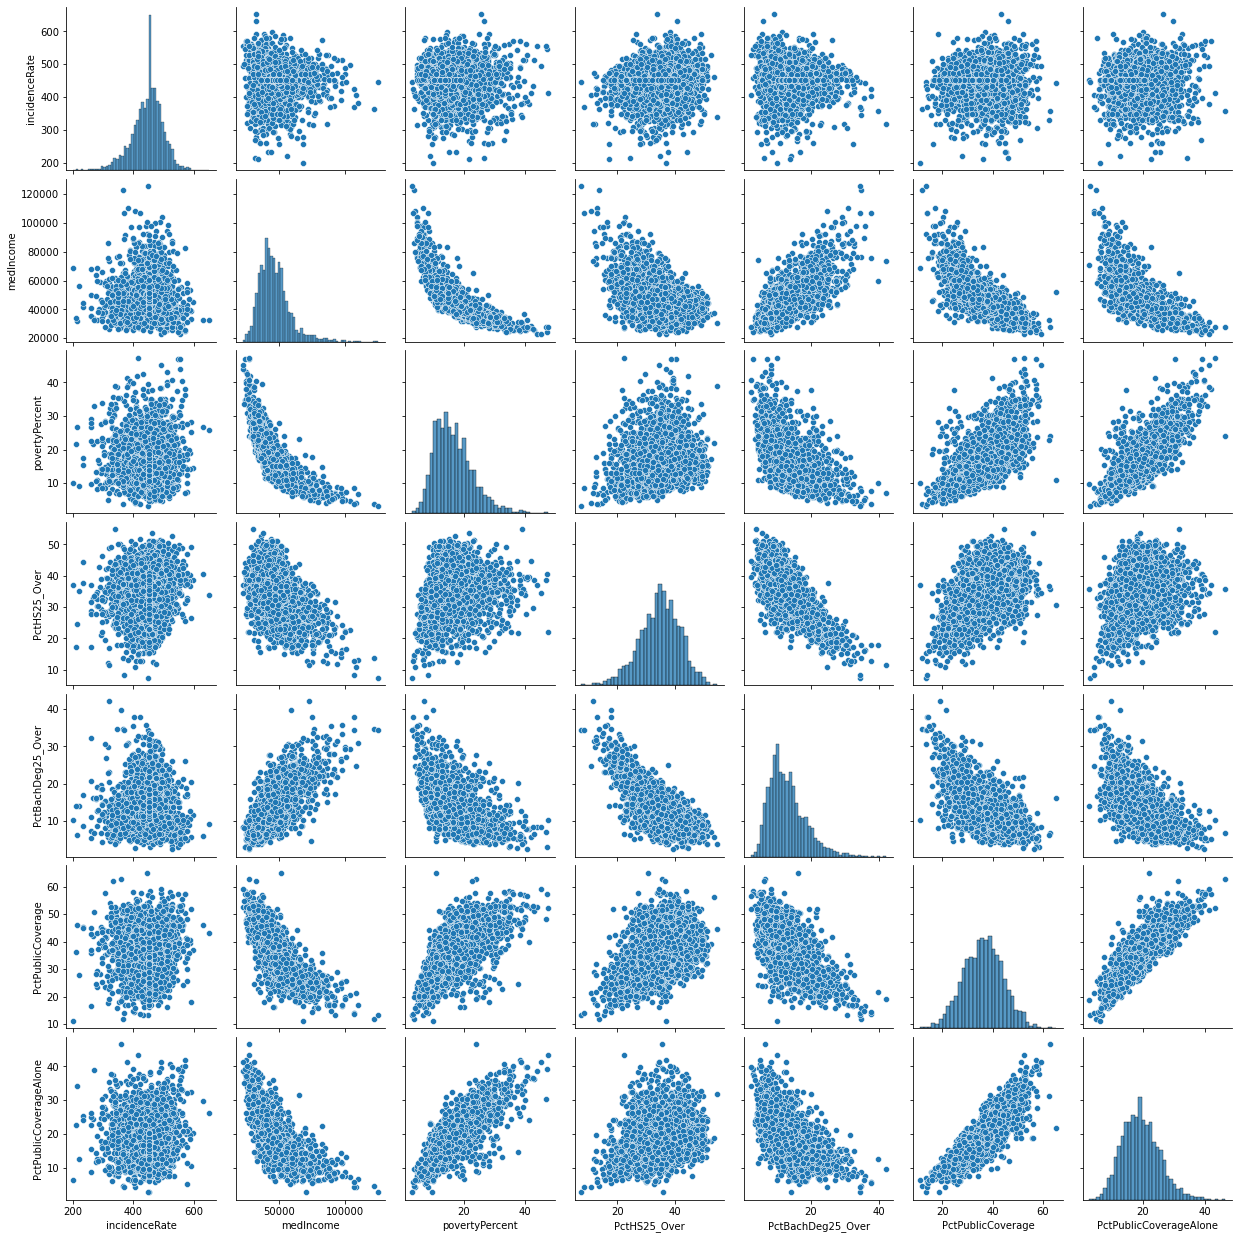

In [7]:
loaded_model = pickle.load(open('OLS_model.sav', 'rb'))
features = ['incidenceRate', 'medIncome', 'povertyPercent', 'PctHS25_Over', 
            'PctBachDeg25_Over', 'PctPublicCoverage', 'PctPublicCoverageAlone']
sns.pairplot(df[features])
plt.show()

Now let's take a look at the coefficients of those independent variables and interpret the results.

In [8]:
coeff_df = pd.DataFrame(loaded_model.coef_, features, columns=['Coefficient'])
coeff_df

,Coefficient
incidenceRate,0.219622
medIncome,0.000006
povertyPercent,0.763480
PctHS25_Over,0.653206
PctBachDeg25_Over,-0.849657
PctPublicCoverage,-0.300650
PctPublicCoverageAlone,1.038225


We can see that a 1% increase in Incidence Rate will cause Death Rate to increase by .2%.  Whereas an increase in 1% of residents in the county over 25 with a Bachelor's Degree, corresponds to a reduction in Death Rate by about .85%.   Alarmingly, there seems to be a 1 to 1 relationship between an increase in Percentage of people in the county with only Public Health Coverage and Death Rate.

However, before we read too much into this there are two important caveats I would make:
1. The performance of our regression overall is not very strong.  With only around a 50% R-Squared, there is still a lot of variability in our data that these models don't explain.
2.  As was pointed out earlier, we still have some multicollinearity with respect to `PctPublicCoverage` and `PctPublicCoverageAlone`, so we really can't thoughtfully interpret these coefficients.  Illustrative of this is the fact that our coefficients seem to contradict each other.  An increase in the overall percentage of the population that has ***any*** Public Health Coverage, reduces death rate.  While an increase in percentage of the population that has ***only*** Public Health Coverage increases death rate. 

## Summary and Conclusion

I would say overall, we were able to build a model that may be somewhat useful in predicting Death Rates in a county based on some basic demographic information.  With an MAE of ~14 per 100,000 and a pretty low R-Squared, it would seem that our model does not perform that well.  However, it is far more useful than looking at any other single independent variable in our dataset.  

Our model, and the analysis leading up to the building of the model, does clearly demonstrate that there are many factors beyond just Incidence Rate that are useful in predicting Death Rate.  In order to refine and improve this model, I would certainly try to obtain more granular demographic data.  Specifically, health related data and more granularity on types/severities of cancer diagnosis would be useful.  Ultimately, this type of analysis would best be performed on an individual basis.  Individual demographics of people diagnosed with cancer (along with basic health, genetic, and specificic diagnosis information) would likely produce the best predictive models.

## Appendix 1 - Data Dictionary
TARGET_deathRate: Dependent variable. Mean per capita (100,000) cancer mortalities(a)

avgAnnCount: Mean number of reported cases of cancer diagnosed annually(a)

avgDeathsPerYear: Mean number of reported mortalities due to cancer(a)

incidenceRate: Mean per capita (100,000) cancer diagoses(a)

medianIncome: Median income per county (b)

popEst2015: Population of county (b)

povertyPercent: Percent of populace in poverty (b)

studyPerCap: Per capita number of cancer-related clinical trials per county (a)

binnedInc: Median income per capita binned by decile (b)

MedianAge: Median age of county residents (b)

MedianAgeMale: Median age of male county residents (b)

MedianAgeFemale: Median age of female county residents (b)

Geography: County name (b)

AvgHouseholdSize: Mean household size of county (b)

PercentMarried: Percent of county residents who are married (b)

PctNoHS18_24: Percent of county residents ages 18-24 highest education attained: less than high school (b)

PctHS18_24: Percent of county residents ages 18-24 highest education attained: high school diploma (b)

PctSomeCol18_24: Percent of county residents ages 18-24 highest education attained: some college (b)

PctBachDeg18_24: Percent of county residents ages 18-24 highest education attained: bachelor's degree (b)

PctHS25_Over: Percent of county residents ages 25 and over highest education attained: high school diploma (b)

PctBachDeg25_Over: Percent of county residents ages 25 and over highest education attained: bachelor's degree (b)

PctEmployed16_Over: Percent of county residents ages 16 and over employed (b)

PctUnemployed16_Over: Percent of county residents ages 16 and over unemployed (b)

PctPrivateCoverage: Percent of county residents with private health coverage (b)

PctPrivateCoverageAlone: Percent of county residents with private health coverage alone (no public assistance) (b)

PctEmpPrivCoverage: Percent of county residents with employee-provided private health coverage (b)

PctPublicCoverage: Percent of county residents with government-provided health coverage (b)

PctPubliceCoverageAlone: Percent of county residents with government-provided health coverage alone (b)

PctWhite: Percent of county residents who identify as White (b)

PctBlack: Percent of county residents who identify as Black (b)

PctAsian: Percent of county residents who identify as Asian (b)

PctOtherRace: Percent of county residents who identify in a category which is not White, Black, or Asian (b)

PctMarriedHouseholds: Percent of married households (b)

BirthRate: Number of live births relative to number of women in county (b)

(a): years 2010-2016

(b): 2013 Census Estimates

